In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Generate full grid of training data
Space_width = 2
Number_of_grid = 160
target_volume = 0.1
length_scale = tf.pow(target_volume, 1/3) # rough estimate of the drop size
TCL_height = length_scale / 100           # thickness of the wedge near the contact line

x_full = np.linspace(-Space_width/2, Space_width/2, Number_of_grid)
y_full = np.linspace(-Space_width/2, Space_width/2, Number_of_grid)
x_grid, y_grid = np.meshgrid(x_full, y_full)

# Convert grid points to tensor once
xy_full = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
xy_full_tensor = tf.convert_to_tensor(xy_full, dtype=tf.float32)

# Define neural network
model = Sequential([
    Input(shape=(2,)),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(1, activation='linear')
])

# Define a trainable variable for the Laplace pressure
laplace_pressure = tf.Variable(0.1, dtype=tf.float32, trainable=True)
laplace_pressure.assign(-(2.0/np.sqrt(3)) / length_scale) # estimate for the initial value




<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=-2.487726926803589>

In [ ]:
# this block is used if you already have a saved model.
from tensorflow.keras.models import load_model

# Load the model
model = load_model('./models/my_pinn_model_Fig1.keras')

# Load the saved variables
data = np.load('./models/my_pinn_state_Fig1.npz')
laplace_pressure.assign(data['laplace_pressure'])


Saving my_pinn_model_Fig1.keras to my_pinn_model_Fig1.keras
Saving my_pinn_state_Fig1.npz to my_pinn_state_Fig1.npz


<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=-3.1186392307281494>

In [ ]:
# this block is used if you do not have a saved mode.
# this warm up process trains the PINN to generate a roughly sperical drop shape.

# Define optimizer first
optimizer_warmup = Adam(learning_rate=1e-4)

# Warmup training to make a drop-ish shape
def spherical_cap_height(xy_tensor):
    x = xy_tensor[:, 0]
    y = xy_tensor[:, 1]
    r2 = tf.square(x) + tf.square(y)
    R = tf.constant(0.5, dtype=tf.float32)
    H0 = tf.constant(0.2, dtype=tf.float32)
    h = H0 * (1 - r2 / tf.square(R))
    return tf.maximum(h, -0.5)

def warmup_model(epochs=3000):
    for epoch in range(epochs):
        with tf.GradientTape() as tape:  # No need for persistent=True here
            target_z = spherical_cap_height(xy_full_tensor)
            z_pred = model(xy_full_tensor)
            warmup_loss = tf.reduce_mean(tf.square(z_pred[:, 0] - target_z))

        # Only train the model (not laplace_pressure)
        grads = tape.gradient(warmup_loss, model.trainable_variables)
        optimizer_warmup.apply_gradients(zip(grads, model.trainable_variables))

        if epoch % 100 == 0:
            print(f"Epoch {epoch+1}: WarmupL={warmup_loss.numpy():.6f}")

warmup_model(epochs = 1000)

Epoch 1: WarmupL=0.067923
Epoch 101: WarmupL=0.055534
Epoch 201: WarmupL=0.054936
Epoch 301: WarmupL=0.054171
Epoch 401: WarmupL=0.049157
Epoch 501: WarmupL=0.028650
Epoch 601: WarmupL=0.003047
Epoch 701: WarmupL=0.002063
Epoch 801: WarmupL=0.001817
Epoch 901: WarmupL=0.001736


800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


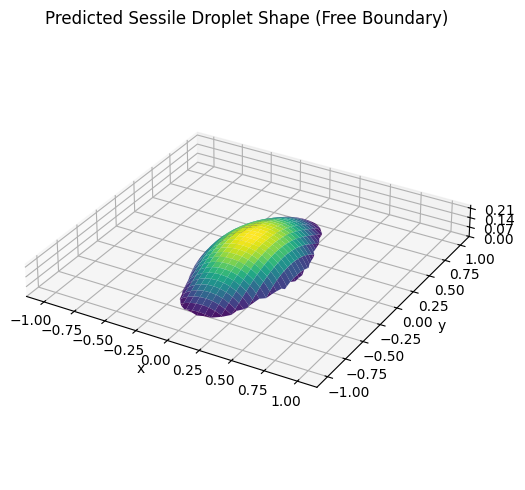

In [ ]:
# this block visualizes the drop generated by the trained PINN

# for the training period, set the number of grid to 160. for the final visualization, set it to 640
Number_of_grid = 160

Space_width = 2
x_full = np.linspace(-Space_width / 2, Space_width / 2, Number_of_grid)
y_full = np.linspace(-Space_width / 2, Space_width / 2, Number_of_grid)
x_grid, y_grid = np.meshgrid(x_full, y_full)
r_grid = np.sqrt(x_grid**2 + y_grid**2)
# Convert grid points to tensor once
xy_full = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
xy_full_tensor = tf.convert_to_tensor(xy_full, dtype=tf.float32)

# Predict and reshape
z_pred = model.predict(xy_full_tensor).ravel()
z_full = np.reshape(z_pred, (Number_of_grid, Number_of_grid))

# Mask: Only show regions where z is significantly above 0 (i.e., part of the drop)
epsilon = 1e-4
z_masked = np.ma.masked_where(z_full < epsilon, z_full)

# Plot surface
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_masked, cmap='viridis')
ax.set_title('Predicted Sessile Droplet Shape (Free Boundary)')
plt.xlabel('x')
plt.ylabel('y')

# Equal aspect ratio for x, y, z
x_range = x_grid.max() - x_grid.min()
y_range = y_grid.max() - y_grid.min()
z_range = z_masked.max() - z_masked.min()
scaling_factor = max(x_range, y_range, z_range)
ax.set_box_aspect([x_range / scaling_factor, y_range / scaling_factor, z_range / scaling_factor])

# Adjust Z-axis tick spacing and limits
z_min = 0.0  # start at zero as you want
z_max = 0.21
z_margin = 0.1 * (z_max - z_min)

ax.set_zlim(z_min, z_max + z_margin)
ax.set_zticks(np.linspace(z_min, z_max, 4))



plt.tight_layout()
plt.show()


In [ ]:
# this is the main training step

optimizer_full = Adam(learning_rate=1e-4)
k_mask = 80.0  # Sharpness of sigmoid mask

# Custom training loop implementing Young-Laplace equation with volume and dynamic contact line
def train_model(epochs=30):

    # assign heterogeneous wettability
    x_pos = xy_full_tensor[:, 0]

    # Define smoothed contact angle function
    x1, x2 = -0.25, 0.25
    width = 0.01
    k = 10.0 / width

    # define hydrophobic and hydrophilic stripes with a transition buffer based on a sigmoid function
    sigmoid = lambda x: 1.0 / (1.0 + tf.exp(-k * x))
    theta_deg = 60.0 - 30.0 * (sigmoid(x_pos - x1) - sigmoid(x_pos - x2))
    target_slope = tf.tan(tf.constant(np.pi / 180.0, dtype=tf.float32) * theta_deg)

    for epoch in range(epochs):
        with tf.GradientTape(persistent=True) as tape:
            # Compute loss
            tape.watch([laplace_pressure])
            tape.watch(xy_full_tensor)  # Now TensorFlow tracks xy_full_tensor
            z_pred = model(xy_full_tensor)
            z = tf.reshape(z_pred, (-1,))

            # Compute gradients using automatic differentiation
            dz_dx = tape.gradient(z, xy_full_tensor)[:, 0]
            dz_dy = tape.gradient(z, xy_full_tensor)[:, 1]
            d2z_dx2 = tape.gradient(dz_dx, xy_full_tensor)[:, 0]
            d2z_dy2 = tape.gradient(dz_dy, xy_full_tensor)[:, 1]
            d2z_dxdy = tape.gradient(dz_dy, xy_full_tensor)[:, 0]

            # Soft mask based on height
            mask_soft = tf.sigmoid(k_mask * z)
            mask_ring = tf.sigmoid(k_mask * (z)) - tf.sigmoid(k_mask * (z - TCL_height))  # ~contact line zone

            # PDE loss (mean curvature - pressure)
            denominator = (1 + dz_dx**2 + dz_dy**2)**(3/2)
            numerator = (1 + dz_dy**2) * d2z_dx2 - 2 * dz_dx * dz_dy * d2z_dxdy + (1 + dz_dx**2) * d2z_dy2
            laplace_residual = numerator / (denominator + 1e-6) - laplace_pressure

            pde_loss = tf.reduce_sum(mask_soft * tf.square(laplace_residual)) / (tf.reduce_sum(mask_soft) + 1e-6)
            laplace_mean = tf.reduce_sum(mask_soft * (numerator / (denominator + 1e-6))) / (tf.reduce_sum(mask_soft) + 1e-6)

            # Contact angle loss
            grad_mag = tf.sqrt(dz_dx**2 + dz_dy**2 + 1e-8)
            angle_loss = tf.reduce_sum(mask_ring * tf.square(grad_mag - target_slope)) / (tf.reduce_sum(mask_ring) + 1e-6)

            # Volume constraint (only inside the contact line)
            dx = Space_width / Number_of_grid  # Grid spacing in x and y
            dy = Space_width / Number_of_grid
            cell_area = dx * dy  # Each grid point represents this much area
            volume = tf.reduce_sum(mask_soft * z) * cell_area
            volume_loss = tf.square(volume - target_volume)

            # Soft constraint to stabilize the drop near the center.
            x = xy_full_tensor[:, 0]
            y = xy_full_tensor[:, 1]
            mass = mask_soft * z  # soft mask × height = "mass"

            total_mass = tf.reduce_sum(mass) + 1e-6
            x_com = tf.reduce_sum(mass * x) / total_mass
            y_com = tf.reduce_sum(mass * y) / total_mass

            center_loss = tf.square(x_com) + tf.square(y_com)


            total_loss = (
                100 * pde_loss / (tf.square(laplace_pressure) + 1e-6) +
                1000 * angle_loss / tf.square(target_slope) +
                100 * volume_loss / tf.square(target_volume) +
                100 * center_loss
            )

        # Compute gradients for model parameters and custom variables
        trainable_vars = model.trainable_variables + [laplace_pressure]
        gradients = tape.gradient(total_loss, trainable_vars)
        optimizer_full.apply_gradients(zip(gradients, trainable_vars))
        if epoch % 10 == 0:  # Only print every 10 epochs
            print(f"Epoch {epoch+1}: Volume={volume.numpy()}, Laplace(C/A)={laplace_pressure.numpy()}, {laplace_mean.numpy()}")
            print(f"Epoch {epoch+1}: PDEL={pde_loss.numpy()}, AngleL={angle_loss.numpy()}")
        # print("Trainable variables:", [v.name for v in trainable_vars])

# Run training loop - if you loaded the file, you don't need to train further.
train_model(epochs=6000)


In [ ]:
# once you obtain the result, save the model here.
model_save_path = 'INSERT PATH HERE'
var_save_path = 'INSERT PATH HERE'

model.save(model_save_path)

np.savez(var_save_path,
         laplace_pressure=laplace_pressure.numpy())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


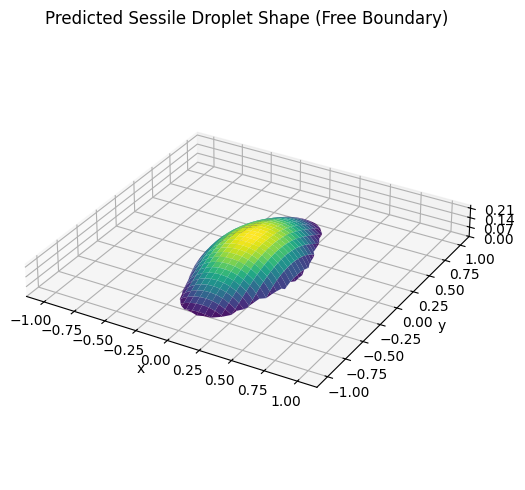

In [6]:
# Predict and reshape
z_pred = model.predict(xy_full_tensor).ravel()
z_full = np.reshape(z_pred, (Number_of_grid, Number_of_grid))

# Mask: Only show regions where z is significantly above 0 (i.e., part of the drop)
epsilon = 1e-4
z_masked = np.ma.masked_where(z_full < epsilon, z_full)

# Plot surface
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_masked, cmap='viridis')
ax.set_title('Predicted Sessile Droplet Shape (Free Boundary)')
plt.xlabel('x')
plt.ylabel('y')

# Equal aspect ratio for x, y, z
x_range = x_grid.max() - x_grid.min()
y_range = y_grid.max() - y_grid.min()
z_range = z_masked.max() - z_masked.min()
scaling_factor = max(x_range, y_range, z_range)
ax.set_box_aspect([x_range / scaling_factor, y_range / scaling_factor, z_range / scaling_factor])

# Adjust Z-axis tick spacing and limits
z_min = 0.0  # start at zero as you want
z_max = 0.21
z_margin = 0.1 * (z_max - z_min)

ax.set_zlim(z_min, z_max + z_margin)
ax.set_zticks(np.linspace(z_min, z_max, 4))



plt.tight_layout()
plt.show()


12800/12800 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step


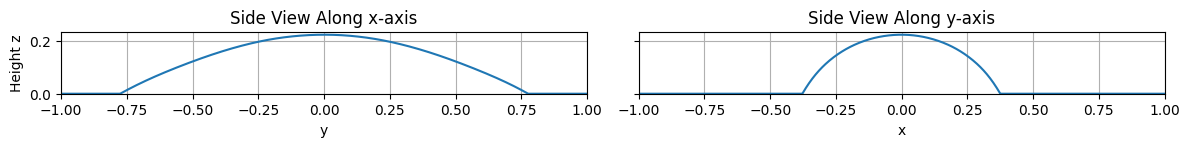

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Number of grid = 160 is used for simulation. 640 is a good number for visualization / contact angle computation.
Number_of_grid = 640

Space_width = 2
x_full = np.linspace(-Space_width / 2, Space_width / 2, Number_of_grid)
y_full = np.linspace(-Space_width / 2, Space_width / 2, Number_of_grid)
x_grid, y_grid = np.meshgrid(x_full, y_full)
r_grid = np.sqrt(x_grid**2 + y_grid**2)
# Convert grid points to tensor once
xy_full = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
xy_full_tensor = tf.convert_to_tensor(xy_full, dtype=tf.float32)

z_pred = model.predict(xy_full_tensor).ravel()
z_full = np.reshape(z_pred, (Number_of_grid, Number_of_grid))

# Slice through center for side views
center_x_index = Number_of_grid // 2
center_y_index = Number_of_grid // 2
z_y_slice = np.maximum(0.0, z_full[:, center_x_index])
z_x_slice = np.maximum(0.0, z_full[center_y_index, :])

# Determine global z limits for consistent axis
z_max = max(np.max(z_y_slice), np.max(z_x_slice))
z_min = 0.0

# Compute finite differences to estimate local slopes
def estimate_max_angle(profile, coords):
    dz = np.diff(profile)
    dx = np.diff(coords)
    slopes = dz / (dx + 1e-8)
    max_slope = np.max(np.abs(slopes))
    return np.degrees(np.arctan(max_slope))

angle_x_max = estimate_max_angle(z_x_slice, x_full)
angle_y_max = estimate_max_angle(z_y_slice, y_full)


# Create side view plots
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# x-axis side view
axs[0].plot(y_full, z_y_slice, label='Slice at x=0')
axs[0].set_title('Side View Along x-axis')
axs[0].set_xlabel('y')
axs[0].set_ylabel('Height z')
axs[0].set_xlim(y_full[0], y_full[-1])
axs[0].set_ylim(z_min, z_max * 1.05)
axs[0].set_aspect('equal')
axs[0].grid(True)
# axs[0].annotate(f"{angle_y_max:.1f}°", xy=(y_full[0]+0.02, z_y_slice[0]+0.01),
#                fontsize=14)  #  larger than default

# y-axis side view
axs[1].plot(x_full, z_x_slice, label='Slice at y=0')
axs[1].set_title('Side View Along y-axis')
axs[1].set_xlabel('x')
axs[1].set_xlim(x_full[0], x_full[-1])
axs[1].set_ylim(z_min, z_max * 1.05)
axs[1].set_aspect('equal')
axs[1].grid(True)
# axs[1].annotate(f"{angle_x_max:.1f}°", xy=(x_full[0]+0.02, z_x_slice[0]+0.01),
#                 fontsize=14)  #  larger than default

plt.tight_layout()
plt.show()


In [8]:
# Compute numerical gradients
dz_dx = np.gradient(z_x_slice, x_full)  # derivative along x at y=0
dz_dy = np.gradient(z_y_slice, y_full)  # derivative along y at x=0

# Find max absolute slopes near each edge (within a few grid points)
edge_n = 5  # number of points to consider at each end

slope_x = abs(dz_dx.max())
slope_y = abs(dz_dy.max())

# Convert slopes to contact angles (in degrees)
angle_x = np.degrees(np.arctan(slope_x))
angle_y = np.degrees(np.arctan(slope_y))

print(f"Estimated contact angle along x-axis (side view): {angle_x:.2f}°")
print(f"Estimated contact angle along y-axis (side view): {angle_y:.2f}°")


Estimated contact angle along x-axis (side view): 59.24°
Estimated contact angle along y-axis (side view): 28.82°
